# Pytorch_Practice_CNN(MNIST)

### 補充：在Pytorch使用gpu訓練
要使用gpu有幾個地方要改：
#### 1. 資料要用cuda()轉換
```python
...
# used for cuda
X_batch = X_batch.cuda()
y_batch = y_batch.cuda()
```
以及
```python
X_test = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor).cuda() / 255
y_test = test_data.test_labels.cuda()
```

#### 2.模型要放到gpu上
```python
cnn = CNN()
# use gpu to train
cnn.cuda()
```

#### 3.如果要將資料轉回cpu運算，則使用cpu()轉回來
像是numpy()不支援在gpu上執行
```python
torch.sum(pred == y_test).cpu().numpy()
```


In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import os

In [2]:
EPOCH = 5
BATCH_SIZE = 500
LR = 0.001

### 1.load data

In [3]:
train_data = torchvision.datasets.MNIST(
    root = './mnist',
    train = True,
    transform = torchvision.transforms.ToTensor(), #將下載後的東西轉成tensor並做Standardization
    download = not(os.path.isdir('./mnist')))
test_data = torchvision.datasets.MNIST(root='./mnist', 
                                       train=False, 
                                       download=not(os.path.isdir('./mnist')))

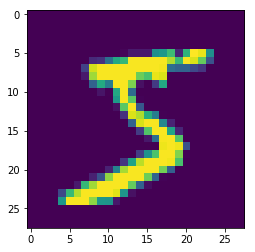

In [4]:
plt.imshow(train_data.train_data[0])

In [5]:
train_loader = Data.DataLoader(dataset=train_data,
                               batch_size=BATCH_SIZE,
                               shuffle=True,
                               num_workers=4)
X_test = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor).cuda() / 255
y_test = test_data.test_labels.cuda()

### 2.build model

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential( # input shape:(1, 28, 28)
            nn.Conv2d(in_channels=1, # channel
                      out_channels=16, # filter number
                      kernel_size=5, # filter size
                      stride=1,
                      padding=2 #padding=(kernel_size-1)/2 when stride=1
                      ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # output shape: (16, 14, 14)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16,  
                      out_channels=32,
                      kernel_size=5,
                      stride=1,
                      padding=2
                      ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # output shape: (32, 7, 7)
        )
        self.out = nn.Linear(in_features=32 * 7 * 7, out_features=10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten
        x = x.view(x.size()[0], -1) # (batch size, 28*28)
        # 另一種寫法
        # x = x.view(-1, 28*28)
        output = self.out(x)
        return output

In [7]:
cnn = CNN()
# use gpu to train
cnn.cuda()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


### 3.Train

In [8]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss() # torch 的crossentropyloss不用做onehot

for epoch in range(EPOCH):
    for step, (X_batch, y_batch) in enumerate(train_loader):
        # used for cuda
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()
        
        output = cnn(X_batch)
        loss = loss_func(output, y_batch) #remember order(pred, groundtruth)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 50 == 0:
            # torch.max回傳兩個tensor，第一個是原tensor的max，第二個是對應的index num
            # index剛好可以對應one-hot，所以可以直接用
            test_output = cnn(X_test)
            pred = torch.max(test_output, dim=1)[1]
            # 有坑注意！不要用sum()，如果要用的話要先讓資料是ndarray type！
            train_acc = torch.sum(pred == y_test).cpu().numpy() / X_test.shape[0]
            train_loss = loss
            print('epoch:', epoch, 'test loss: %.4f' % train_loss, 'test acc:', train_acc)

epoch: 0 test loss: 2.3174 test acc: 0.1794
epoch: 0 test loss: 0.3806 test acc: 0.9034
epoch: 0 test loss: 0.2895 test acc: 0.9361
epoch: 1 test loss: 0.1941 test acc: 0.9449
epoch: 1 test loss: 0.1492 test acc: 0.9607
epoch: 1 test loss: 0.1313 test acc: 0.9699
epoch: 2 test loss: 0.1342 test acc: 0.9727
epoch: 2 test loss: 0.0939 test acc: 0.9767
epoch: 2 test loss: 0.0630 test acc: 0.9792
epoch: 3 test loss: 0.0736 test acc: 0.9784
epoch: 3 test loss: 0.0985 test acc: 0.9801
epoch: 3 test loss: 0.1375 test acc: 0.981
epoch: 4 test loss: 0.0792 test acc: 0.983
epoch: 4 test loss: 0.0499 test acc: 0.9831
epoch: 4 test loss: 0.0388 test acc: 0.9836


### 4.Predict

In [9]:
pred_output = cnn(X_test[:10])
y_pred = torch.max(pred_output, dim=1)[1]
print('prediction:', y_pred)
print('groundtruth:', y_test[:10])

prediction: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], device='cuda:0')
groundtruth: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], device='cuda:0')
